In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import pandas as pd
import seaborn as sns
from panco2 import PressureProfileFitter
from utils import gNFW
import results
import os
from astropy.table import Table
from fklib import mapview

# Test 0

- $M_{500} = 3.5 \times 10^{14} \, M_\odot$, $z= 0.865$
- A10 pressure profile
- 4 arcmin map, 18 arcsec FWHM beam, no transfer function
- White noise

## Create map

In [ ]:
path = "../tests/test0/"

ppf = PressureProfileFitter(
    "../tests/nk2_actj0215_15.fits",
    4, 5, 0.865, M_500=3.5e14, map_size=4.0
)
r_bins = np.logspace(
    np.log10(ppf.cluster.arcsec2kpc(9.0)), np.log10(ppf.cluster.arcsec2kpc(180.0)), 50
)
ppf.define_model("binned", r_bins)
P_bins = gNFW(ppf.model.r_bins, *ppf.cluster.A10_params)
par_vec = np.append(P_bins, [-12.0, 0.0])
ppf.add_filtering(beam_fwhm=18.0)

ppf.write_sim_map(par_vec, f"{path}/map.fits")

## Fit

In [ ]:
path = "../tests/test0/"

ppf = PressureProfileFitter(
    f"{path}/map.fits",
    1,
    2,
    0.865,
    M_500=3.5e14,
)

r_bins = np.logspace(
    np.log10(ppf.cluster.arcsec2kpc(9.0)), np.log10(ppf.cluster.arcsec2kpc(180.0)), 5
)

ppf.define_model("binned", r_bins)
P_bins = gNFW(ppf.model.r_bins, *ppf.cluster.A10_params)
par_vec = np.append(P_bins, [-11.9, 0.0])
par_dic = ppf.model.par_vec2dic(par_vec)

ppf.add_filtering(beam_fwhm=18.0)
ppf.define_priors(
    P_bins=[ss.loguniform(0.1 * P, 10.0 * P) for P in P_bins],
    conv=ss.norm(-11.90, 1.19),
    zero=ss.norm(0.0, 1e-4)
)
ppf.dump_to_file(f"{path}/ppf.panco2")

In [ ]:
f = ppf.run_mcmc(30, 1e4, 6, n_check=1e3, out_chains_file=f"{path}/raw_chains.npz")

In [ ]:
chains_clean = results.load_chains(f"{path}/raw_chains.npz", 200, 20)

In [ ]:
plt.close("all")
results.set_plot_style("seaborn")
results.mcmc_corner_plot(chains_clean, model=ppf.model, show_probs=False, filename=f"{path}/corner.png")
results.mcmc_trace_plot(chains_clean, filename=f"{path}/trace.png")
plt.close("all")
results.set_plot_style("seaborn")
fig = results.plot_results(ppf, chains_clean, truth_vec=par_vec)
fig.savefig(f"{path}/results.pdf")

# Test 1

- $M_{500} = 3.5 \times 10^{14} \, M_\odot$, $z= 0.865$
- A10 pressure profile
- 4 arcmin map, 18 arcsec FWHM beam, no transfer function
- White noise

## Create map

In [ ]:
path = "../tests/test1/"

ppf = PressureProfileFitter(
    "../tests/nk2_actj0215_15.fits",
    4, 5, 0.865, M_500=3.5e14, map_size=4.0
)
r_bins = np.logspace(
    np.log10(ppf.cluster.arcsec2kpc(9.0)), np.log10(ppf.cluster.arcsec2kpc(180.0)), 50
)
ppf.define_model("binned", r_bins)
gnfw_par = np.copy(ppf.cluster.A10_params)
gnfw_par[0] *= 3.2 / 8.4
gnfw_par[1] *= 1.0510 / 1.083
gnfw_par[2] = 1.40
gnfw_par[4] = 0.20
P_bins = gNFW(ppf.model.r_bins, *gnfw_par)
par_vec = np.append(P_bins, [-12.0, 0.0])
ppf.add_filtering(beam_fwhm=18.0)

ppf.write_sim_map(par_vec, f"{path}/map.fits")

## Fit

In [ ]:
path = "../tests/test1/"

ppf = PressureProfileFitter(
    f"{path}/map.fits",
    1,
    2,
    0.865,
    M_500=3.5e14,
)

r_bins = np.logspace(
    np.log10(ppf.cluster.arcsec2kpc(9.0)), np.log10(ppf.cluster.arcsec2kpc(180.0)), 5
)

ppf.define_model("binned", r_bins)
gnfw_par = np.copy(ppf.cluster.A10_params)
gnfw_par[0] *= 3.2 / 8.4
gnfw_par[1] *= 1.0510 / 1.083
gnfw_par[2] = 1.40
gnfw_par[4] = 0.20
P_bins = gNFW(ppf.model.r_bins, *gnfw_par)
par_vec = np.append(P_bins, [-12.0, 0.0])
par_dic = ppf.model.par_vec2dic(par_vec)

ppf.add_filtering(beam_fwhm=18.0)
ppf.define_priors(
    P_bins=[ss.loguniform(0.1 * P, 10.0 * P) for P in P_bins],
    conv=ss.norm(-11.90, 1.19),
    zero=ss.norm(0.0, 1e-4)
)
ppf.dump_to_file(f"{path}/ppf.panco2")

In [ ]:
f = ppf.run_mcmc(30, 1e4, 6, n_check=1e3, out_chains_file=f"{path}/raw_chains.npz")

In [ ]:
chains_clean = results.load_chains(f"{path}/raw_chains.npz", 200, 20)

In [ ]:
plt.close("all")
results.set_plot_style("seaborn")
results.mcmc_corner_plot(chains_clean, model=ppf.model, show_probs=False, filename=f"{path}/corner.png")
results.mcmc_trace_plot(chains_clean, filename=f"{path}/trace.png")
plt.close("all")
results.set_plot_style("seaborn")
fig = results.plot_results(ppf, chains_clean, truth_vec=par_vec)
fig.savefig(f"{path}/results.pdf")

# Test 2

- $M_{500} = 3.5 \times 10^{14} \, M_\odot$, $z= 0.865$
- A10 pressure profile
- 4 arcmin map, 18 arcsec FWHM beam, transfer function
- White noise

# Test 3

- $M_{500} = 5.5 \times 10^{14} \, M_\odot$, $z= 0.565$
- A10 pressure profile
- 6 arcmin map, 18 arcsec FWHM beam, transfer function
- White noise

## Create map

In [ ]:
path = "../tests/test3/"
if not os.path.isdir(path):
    os.makedirs(path)

ppf = PressureProfileFitter(
    "../tests/nk2_actj0215_15.fits",
    4, 5, 0.565, M_500=5.5e14, map_size=6.0
)
r_bins = np.logspace(
    np.log10(ppf.cluster.arcsec2kpc(9.0)), np.log10(ppf.cluster.arcsec2kpc(180.0)), 50
)
ppf.define_model("binned", r_bins)
P_bins = gNFW(ppf.model.r_bins, *ppf.cluster.A10_params)
par_vec = np.append(P_bins, [-12.0, 0.0])

tf = Table.read("../tests/nk2_tf.fits")
ppf.add_filtering(beam_fwhm=18.0, k=tf["k"].to("arcmin-1").value, tf_k=tf["tf_2mm"].value)

ppf.write_sim_map(par_vec, f"{path}/map.fits")

## Fit

In [ ]:
path = "../tests/test3/"

ppf = PressureProfileFitter(
    f"{path}/map.fits",
    1,
    2,
    0.565,
    M_500=5.5e14,
)

r_bins = np.logspace(
    np.log10(ppf.cluster.arcsec2kpc(9.0)), np.log10(ppf.cluster.arcsec2kpc(180.0)), 8
)

ppf.define_model("binned", r_bins)
P_bins = gNFW(ppf.model.r_bins, *ppf.cluster.A10_params)
par_vec = np.append(P_bins, [-11.9, 0.0])
par_dic = ppf.model.par_vec2dic(par_vec)

ppf.add_filtering(beam_fwhm=18.0, k=tf["k"].to("arcmin-1").value, tf_k=tf["tf_2mm"].value)
ppf.define_priors(
    P_bins=[ss.loguniform(0.1 * P, 10.0 * P) for P in P_bins],
    conv=ss.norm(-11.90, 1.19),
    zero=ss.norm(0.0, 1e-4)
)
ppf.dump_to_file(f"{path}/ppf.panco2")

In [ ]:
f = ppf.run_mcmc(30, 1e4, 6, n_check=1e3, out_chains_file=f"{path}/raw_chains.npz")

In [ ]:
chains_clean = results.load_chains(f"{path}/raw_chains.npz", 200, 20)

In [ ]:
plt.close("all")
results.set_plot_style("seaborn")
results.mcmc_corner_plot(chains_clean, model=ppf.model, show_probs=False, filename=f"{path}/corner.png")
results.mcmc_trace_plot(chains_clean, filename=f"{path}/trace.png")
plt.close("all")
results.set_plot_style("seaborn")
fig = results.plot_results(ppf, chains_clean, truth_vec=par_vec)
fig.savefig(f"{path}/results.pdf")

# Test 4

- $M_{500} = 5 \times 10^{14} \, M_\odot$, $z = 0.1$
- A10 pressure profile
- 30 arcmin map, 1 arcmin FWHM beam, no transfer function
- White noise

## Create map

In [ ]:
path = "../tests/test4/"
if not os.path.isdir(path):
    os.makedirs(path)

ppf = PressureProfileFitter(
    "../tests/ACTlike.fits",
    1, 2, 0.1, M_500=5e14, map_size=61.0
)
r_bins = np.logspace(
    np.log10(ppf.cluster.arcsec2kpc(30.0)), np.log10(ppf.cluster.arcsec2kpc(3600.0)), 100
)
ppf.define_model("binned", r_bins)
P_bins = gNFW(ppf.model.r_bins, *ppf.cluster.A10_params)
par_vec = np.append(P_bins, [1.0, 0.0])

ppf.add_filtering(beam_fwhm=60.0)

ppf.write_sim_map(par_vec, f"{path}/map.fits")
mapview.fitsview(f"{path}/map.fits", 1, smooth=0.0, imrange="sym")

## Fit

/Users/fkeruzore/.miniconda3/envs/panco2/lib/python3.10/site-packages/astropy/visualization/wcsaxes/core.py:234: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)


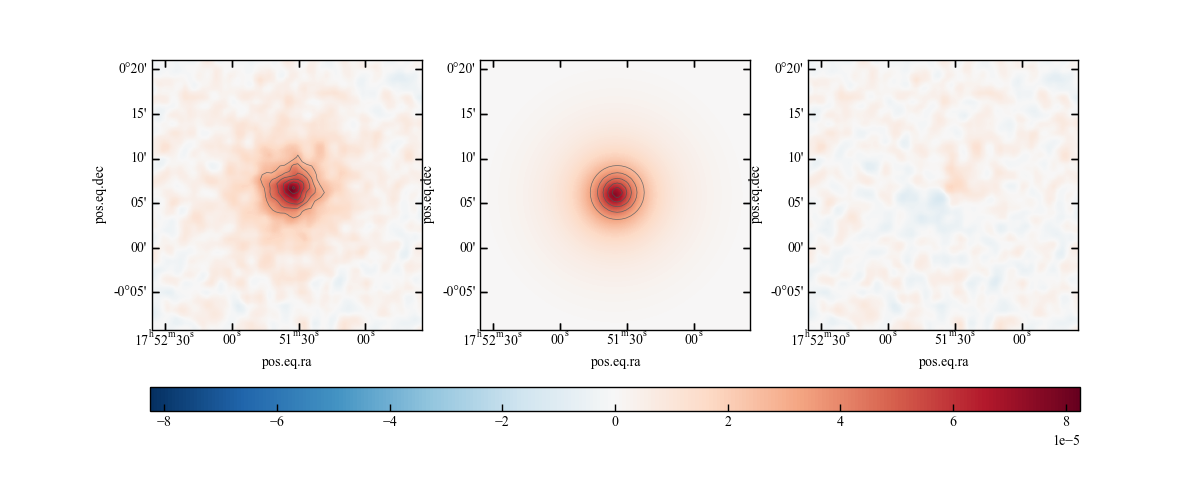

In [3]:
path = "../tests/test4/"

ppf = PressureProfileFitter(
    f"{path}/map.fits",
    1, 2, 0.1, M_500=5e14, map_size=30.0
)

r_bins = np.logspace(
    np.log10(ppf.cluster.arcsec2kpc(30.0)), np.log10(ppf.cluster.arcsec2kpc(15.0 * 60)), 8
)

ppf.define_model("binned", r_bins)
P_bins = gNFW(ppf.model.r_bins, *ppf.cluster.A10_params)
par_vec = np.append(P_bins, [1.0, 0.0])
par_dic = ppf.model.par_vec2dic(par_vec)

ppf.add_filtering(beam_fwhm=60.0)
ppf.define_priors(
    P_bins=[ss.loguniform(0.1 * P, 10.0 * P) for P in P_bins],
    conv=ss.norm(1.0, 0.1),
    zero=ss.norm(0.0, 1e-6)
)
ppf.dump_to_file(f"{path}/ppf.panco2")
results.plot_data_model_residuals(ppf, par_vec=par_vec, lims="sym", smooth=0)

In [ ]:
f = ppf.run_mcmc(30, 1e4, 6, n_check=1e3, out_chains_file=f"{path}/raw_chains.npz")

In [4]:
chains_clean = results.load_chains(f"{path}/raw_chains.npz", 200, 20)

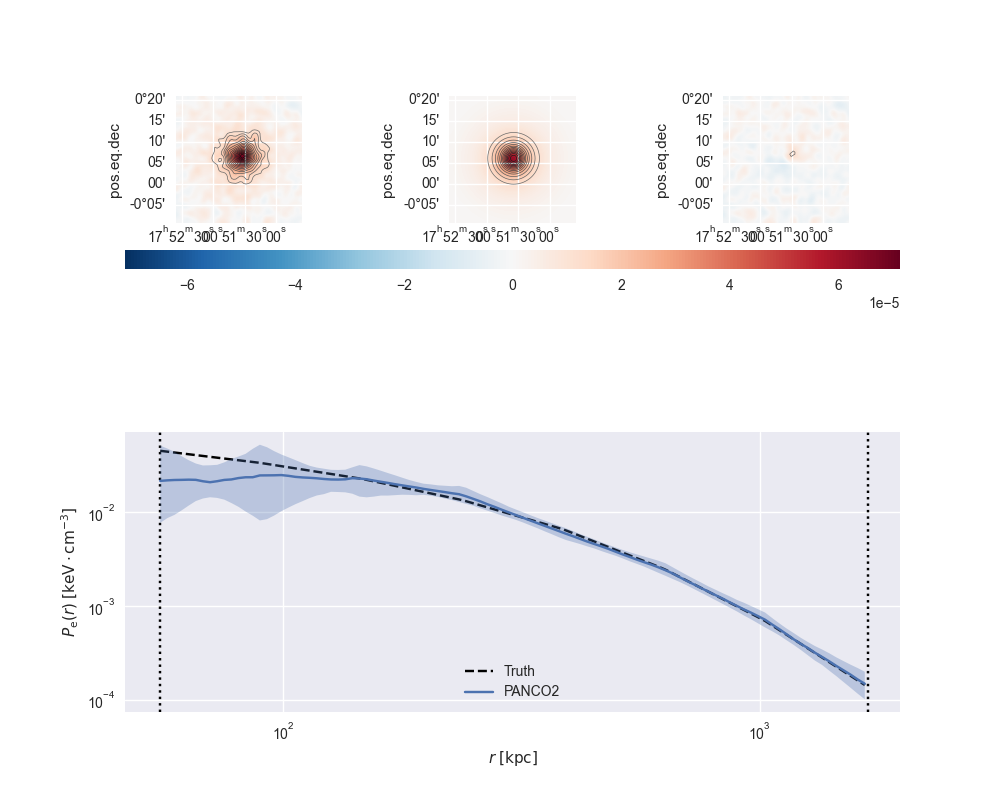

In [8]:
plt.close("all")
results.set_plot_style("seaborn")
results.mcmc_corner_plot(chains_clean, model=ppf.model, show_probs=False, filename=f"{path}/corner.png")
results.mcmc_trace_plot(chains_clean, show_probs=False, filename=f"{path}/trace.png")
fig = results.plot_results(ppf, chains_clean, truth_vec=par_vec)
fig.savefig(f"{path}/results.pdf")

## Create map

In [ ]:
path = "../tests/test5/"
if not os.path.isdir(path):
    os.makedirs(path)

ppf = PressureProfileFitter(
    "../tests/ACTlike.fits",
    1, 2, z=0.1, M_500=5e14, map_size=30.0
)
r_bins = np.logspace(
    np.log10(ppf.cluster.arcsec2kpc(30.0)), np.log10(ppf.cluster.arcsec2kpc(3600.0)), 100
)
ppf.define_model("binned", r_bins)
P_bins = gNFW(ppf.model.r_bins, *ppf.cluster.A10_params)
par_vec = np.append(P_bins, [1.0, 0.0])

ppf.add_filtering(beam_fwhm=60.0)

ppf.write_sim_map(par_vec, f"{path}/map.fits")
mapview.fitsview(f"{path}/map.fits", 1, smooth=0.0, imrange="sym")

## Fit

In [ ]:
path = "../tests/test5/"

ppf = PressureProfileFitter(
    f"{path}/map.fits",
    1, 2, z=0.1, M_500=5e14, map_size=10.0
)

r_bins = np.logspace(
    np.log10(ppf.cluster.arcsec2kpc(30.0)), np.log10(ppf.cluster.arcsec2kpc(5.0 * 60)), 8
)

ppf.define_model("binned", r_bins)
P_bins = gNFW(ppf.model.r_bins, *ppf.cluster.A10_params)
par_vec = np.append(P_bins, [1.0, 0.0])
par_dic = ppf.model.par_vec2dic(par_vec)

ppf.add_filtering(beam_fwhm=60.0)
ppf.define_priors(
    P_bins=[ss.loguniform(0.1 * P, 10.0 * P) for P in P_bins],
    conv=ss.norm(1.0, 0.1),
    zero=ss.norm(0.0, 1e-6)
)
ppf.dump_to_file(f"{path}/ppf.panco2")
results.plot_data_model_residuals(ppf, par_vec=par_vec, lims="sym", smooth=1.0)

In [ ]:
f = ppf.run_mcmc(30, 1e4, 6, n_check=1e3, out_chains_file=f"{path}/raw_chains.npz")

In [ ]:
chains_clean = results.load_chains(f"{path}/raw_chains.npz", 200, 20)

In [ ]:
plt.close("all")
results.set_plot_style("seaborn")
results.mcmc_corner_plot(chains_clean, model=ppf.model, show_probs=False, filename=f"{path}/corner.png")
results.mcmc_trace_plot(chains_clean, show_probs=False, filename=f"{path}/trace.png")
fig = results.plot_results(ppf, chains_clean, truth_vec=par_vec)
fig.savefig(f"{path}/results.pdf")